## Pipeline

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn

from datasets import load_dataset
from transformers import pipeline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import sys

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# 判断可用的设备是 CPU 还是 GPU，并将模型移动到对应的计算资源设备上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#文本分类
classifier = pipeline("sentiment-analysis")

result = classifier("This is a great movie. I enjoyed it a lot!")[0]
print(result)

result = classifier("This movie is so bad, I almost fell asleep.")[0]
print(result)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'label': 'POSITIVE', 'score': 0.9998773336410522}
{'label': 'NEGATIVE', 'score': 0.9997857213020325}


## 数据集查看

In [3]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')# 加载imdb数据集
print(imdb_dataset['train'][0]) # 查看第一条数据
print(imdb_dataset['train'][-1]) # 查看最后一条数据

Found cached dataset imdb (C:/Users/Jack/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## 数据处理

In [4]:
#定义数据集
class Dataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.dataset = load_dataset(path='imdb', split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        text = self.dataset[i]['text']
        label = self.dataset[i]['label']
        return text, label


train_dataset = Dataset('train')
test_dataset = Dataset('test')

Found cached dataset imdb (C:/Users/Jack/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (C:/Users/Jack/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [5]:
print(len(train_dataset), len(test_dataset))

25000 25000


## 词元化

In [6]:
from transformers import AutoTokenizer

#加载Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [7]:
# 数据集处理函数
def collate_fn(data):
    sents = [i[0] for i in data]
    labels = [i[1] for i in data]

    #编码
    data = tokenizer.batch_encode_plus(batch_text_or_text_pairs=sents,
                                   truncation=True,
                                   padding='max_length',
                                   max_length=500,
                                   return_tensors='pt',
                                   return_length=True)

    #input_ids:编码之后的数字
    #attention_mask:是补零的位置是0,其他位置是1
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    token_type_ids = data['token_type_ids']
    labels = torch.LongTensor(labels)

    return input_ids, attention_mask, token_type_ids, labels


#定义数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                     batch_size=32,
                                     collate_fn=collate_fn,
                                     shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=32,
                                              collate_fn=collate_fn,
                                              shuffle=True)


## 建立模型

In [8]:
from transformers import BertModel

#加载预训练bert模型
pretrained = BertModel.from_pretrained('bert-base-cased').to(device)

#不训练,不需要计算梯度
for param in pretrained.parameters():
    param.requires_grad_(False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# 定义下游任务模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids)
        out = self.fc(out.last_hidden_state[:, 0]) # 最后一层隐藏层作为输入
        out = out.softmax(dim=1)
        return out

model = Model().to(device)

In [10]:
# 定义训练器
class Trainer:
    def __init__(self, model, train_loader, valid_loader):
        # 初始化训练数据集和验证数据集的dataloader
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.device = device
        self.model = model.to(self.device)
        
        # 定义优化器、损失函数和学习率调度器
        self.optimizer = optim.AdamW(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)
        
        # 记录训练过程中的损失和验证过程中的准确率
        self.train_losses = []
        self.val_accuracy = []
    
    def train(self, num_epochs):
        # tqdm用于显示进度条并评估任务时间开销
        for epoch in tqdm(range(num_epochs), file=sys.stdout):
            # 记录损失值
            total_loss = 0

            # 批量训练
            self.model.train()
            
            for input_ids, attention_mask, token_type_ids, labels in train_loader:
                # 预测、损失函数、反向传播
                self.optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids.to(self.device), attention_mask=attention_mask.to(self.device), token_type_ids=token_type_ids.to(self.device)).to(self.device)
                loss = self.criterion(outputs, labels.to(self.device))
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            
            # 更新优化器的学习率
            self.scheduler.step()
            # 计算验证集的准确率
            accuracy = self.validate()
            
            # 记录训练集损失和验证集准确率
            self.train_losses.append(total_loss)
            self.val_accuracy.append(accuracy)
            
            # 打印中间值
            tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(
                epoch, self.train_losses[-1], self.val_accuracy[-1]))
    
    def validate(self):
        # 测试模型，不计算梯度
        self.model.eval()
        
        # 记录总数和预测正确数
        total = 0
        correct = 0
        
        with torch.no_grad():
            for input_ids, attention_mask, token_type_ids, labels in self.valid_loader:
                outputs = self.model(input_ids=input_ids.to(self.device), attention_mask=attention_mask.to(self.device), token_type_ids=token_type_ids.to(self.device)).to(self.device)
                # 记录验证集总数和预测正确数
                total += labels.size(0)
                correct += (outputs.argmax(1) == labels.to(self.device)).sum().item()
        
        # 返回准确率
        accuracy = correct / total
        return accuracy

## 模型训练和验证

In [11]:
# 创建一个 Trainer 类的实例
trainer = Trainer(model, train_loader, test_loader)
# 训练模型，迭代 30 个周期
trainer.train(num_epochs = 30)

Epoch: 0 Loss: 434.53685945272446 Acc: 0.7914532650448144
Epoch: 1 Loss: 402.5158587694168 Acc: 0.8007762483994878
Epoch: 2 Loss: 393.65125730633736 Acc: 0.801576504481434
Epoch: 3 Loss: 389.8109784722328 Acc: 0.8057378361075545
Epoch: 4 Loss: 386.33617067337036 Acc: 0.8108994878361075
Epoch: 5 Loss: 383.81841921806335 Acc: 0.810699423815621
Epoch: 6 Loss: 382.1445892751217 Acc: 0.8136603713188221
Epoch: 7 Loss: 380.45632472634315 Acc: 0.8143806017925737
Epoch: 8 Loss: 379.21452555060387 Acc: 0.8153409090909091
Epoch: 9 Loss: 378.1194171011448 Acc: 0.817381562099872
Epoch: 10 Loss: 377.32714772224426 Acc: 0.8139004481434059
Epoch: 11 Loss: 376.20741629600525 Acc: 0.8183418693982074
Epoch: 12 Loss: 375.6312824189663 Acc: 0.8190220870678617
Epoch: 13 Loss: 374.8075669705868 Acc: 0.8184619078104993
Epoch: 14 Loss: 374.4073523283005 Acc: 0.819182138284251
Epoch: 15 Loss: 373.81411695480347 Acc: 0.8206626120358514
Epoch: 16 Loss: 373.27428355813026 Acc: 0.819822343149808
Epoch: 17 Loss: 372

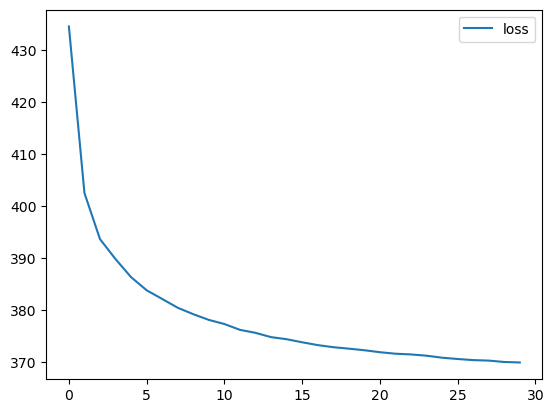

In [12]:
# 使用Matplotlib绘制损失曲线图
plt.plot(trainer.train_losses, label='loss')
plt.legend()
plt.show()

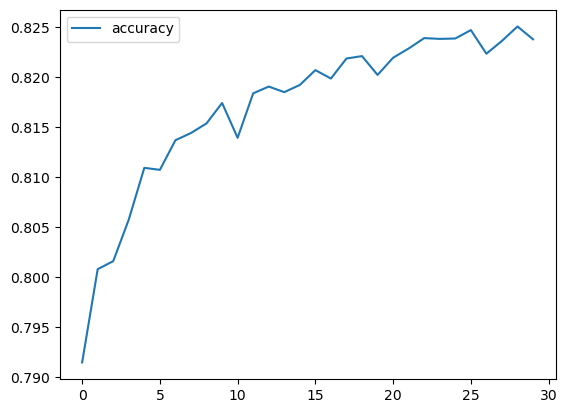

In [13]:
# 使用Matplotlib绘制准确率曲线图
plt.plot(trainer.val_accuracy, label='accuracy')
plt.legend()
plt.show()

## 直接finetune

In [15]:
# 导入必要的库
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

# 加载数据集
dataset = load_dataset("imdb")

# 加载 BERT 分词器
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# 定义用于对输入文本进行分词的函数
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# 对数据集进行分词处理
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 从数据集中选择一小部分用于训练和测试
small_train_dataset = tokenized_datasets["train"].shuffle(seed=0).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=0).select(range(1000))

# 加载 BERT-base-cased 模型用于序列分类任务
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

# 加载准确率度量
metric = evaluate.load("accuracy")

# 定义用于计算评估指标的函数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 设置训练参数
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10, 
    evaluation_strategy="epoch")

# 创建一个 Trainer 实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# 训练模型
trainer.train()

# 将训练好的模型保存到磁盘上
model.save_pretrained('./results/imdb_model')

Found cached dataset imdb (C:/Users/Jack/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Jack\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-23dbfa0878e525bf.arrow
Loading cached processed dataset at C:\Users\Jack\.cache\huggingface\datasets\imdb\plain_text\1.0.0\d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0\cache-9fcb76b56aad9b74.arrow


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.310240,0.866000
2,No log,0.558114,0.878000
3,No log,0.913532,0.827000
4,0.290100,0.651401,0.887000
5,0.290100,0.673469,0.891000
6,0.290100,0.708808,0.896000
7,0.290100,0.855462,0.889000
8,0.016900,0.835452,0.889000
9,0.016900,0.846489,0.890000
10,0.016900,0.834561,0.895000


In [16]:
# 加载模型
model = AutoModelForSequenceClassification.from_pretrained('./results/imdb_model')

# 创建pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# 测试模型
result = classifier('This is a great movie. I enjoyed it a lot!')
print(result)

# 测试模型
result = classifier('This movie is so bad, I almost fell asleep.')
print(result)

[{'label': 'LABEL_1', 'score': 0.9999207258224487}]
[{'label': 'LABEL_0', 'score': 0.9998856782913208}]
